In [1]:
import shapely
import geopandas as gpd
import numpy as np
import pandas as pd
import pathlib
import rasterio
import cv2
import xarray as xr
import scipy

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches

from matplotlib.colors import LightSource

In [2]:
data_dir = pathlib.Path("~/data/vcl/dataset").expanduser()

In [3]:
sat_extent = rasterio.open(data_dir / "test3.tif")

extent = gpd.read_file(data_dir / "bounding_box.shp").to_crs(epsg=28992).iloc[0].geometry

ds = xr.open_dataset(data_dir / "concentratie_data_gw_model.nc")
ds_b0 = rasterio.open(data_dir / "originele_bodem.tif")

In [4]:
# Get vertices of geometry (rectangle)
coords = list(extent.exterior.coords)
coords = pd.DataFrame(coords)
coords.columns = ["x", "y"]

# Get minimum and maximum x and y values from vertices
xmin = coords.idxmin(0)["x"]
ymin = coords.idxmin(0)["y"]
xmax = coords.idxmax(0)["x"]
ymax = coords.idxmax(0)["y"]

# Find bottom left point and bottom right point of original extent
bottom_point = [coords.iloc[ymin]["x"], coords.iloc[ymin]["y"]]
right_point = [coords.iloc[xmax]["x"], coords.iloc[xmax]["y"]]

# Compute the rotation angle of original extent
o = right_point[1] - bottom_point[1]
a = right_point[0] - bottom_point[0]

angle = np.rad2deg(np.arctan(o / a))

# Get center point of extent
mid_point = extent.centroid.coords[0]

In [5]:
def sat_and_bodem_bounds(sat, bodem):
    # Get bounds of bodem and sat files
    sat_bounds = sat.bounds
    bodem_bounds = bodem.bounds

    # Compute the minimum (and maximum) point which sat and bodem still share in their extent
    left = max([sat_bounds[0], bodem_bounds[0]])
    bottom = max([sat_bounds[1], bodem_bounds[1]])
    right = min([sat_bounds[2], bodem_bounds[2]])
    top = min([sat_bounds[3], bodem_bounds[3]])

    return left, right, bottom, top


# Get bounds of bodem and sat files
left, right, bottom, top = sat_and_bodem_bounds(sat_extent, ds_b0)

# Get transform of the files (for indices instead of coordinates)
t_sat = sat_extent.transform
t_bodem = ds_b0.transform

# Apply inverse transform to extrema to get indices of arrays
window_bodem_min = ~t_bodem * (left, top)
window_bodem_max = ~t_bodem * (right, bottom)

window_sat_min = ~t_sat * (left, top)
window_sat_max = ~t_sat * (right, bottom)

bodem = ds_b0.read(1)

# Get satellite image
sat = sat_extent.read()
sat = np.transpose(sat, (1, 2, 0))

# Get extent of arrays from indices
bodem = bodem[
    int(window_bodem_min[1]) : int(window_bodem_max[1]),
    int(window_bodem_min[0]) : int(window_bodem_max[0]),
]
sat = sat[
    int(window_sat_min[1]) : int(window_sat_max[1]),
    int(window_sat_min[0]) : int(window_sat_max[0]),
]

# Scale satellite image to bathymetry shapes
sat_scaled = (
    cv2.resize(
        sat, dsize=(bodem.shape[1], bodem.shape[0]), interpolation=cv2.INTER_CUBIC
    ).astype("float64")
    / 255
)

ls = LightSource(azdeg=315, altdeg=45)

# Add shade to scaled image
img_shade = ls.shade_rgb(sat_scaled, bodem, vert_exag=5, blend_mode="soft")

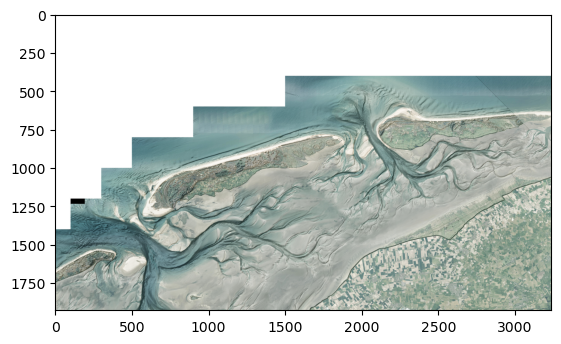

In [6]:
fig, ax = plt.subplots()
ax.imshow(img_shade)

In [7]:
# Compute combined bounds of satellite image and bathymetry
plt_extent = sat_and_bodem_bounds(sat_extent, ds_b0)

# Get plot lims of rotated extent (rotated such that extent has an angle of 0 with the horizontal axis)
rotated_extent = shapely.affinity.rotate(extent, -angle)

lims = rotated_extent.exterior.bounds

(592561.530811512, 607623.7318780796)

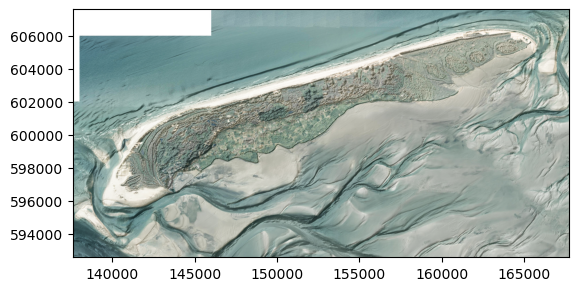

In [8]:
fig, ax = plt.subplots()
ax.imshow(img_shade, extent=plt_extent)

ax.set_xlim(lims[0], lims[2])
ax.set_ylim(lims[1], lims[3])

(592561.530811512, 607623.7318780796)

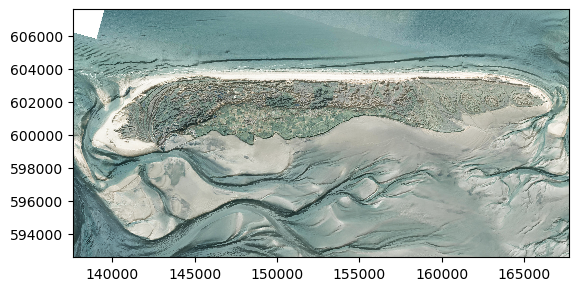

In [9]:
fig, ax = plt.subplots()

im = ax.imshow(img_shade, extent=plt_extent,
               clip_on=True, interpolation='none'
)

transform = mtransforms.Affine2D().rotate_deg_around(
    mid_point[0], mid_point[1], -angle
)
trans_data = transform + ax.transData
im.set_transform(trans_data)

ax.set_xlim(lims[0], lims[2])
ax.set_ylim(lims[1], lims[3])

In [10]:
conc_bounds = (
    ds.conc.x.values[0],
    ds.conc.y.values[-1],
    ds.conc.x.values[-1],
    ds.conc.y.values[0],
)

dummy = scipy.ndimage.rotate(ds.conc.values[0, ...], -angle, reshape=True, order=0, cval=np.nan)
rot_ds = np.zeros((ds.conc.shape[0], dummy.shape[0], dummy.shape[1]))

for i in range(rot_ds.shape[0]):
    rot_ds[i, ...] = scipy.ndimage.rotate(
        ds.conc.values[i, ...], -angle, reshape=True, order=0, cval=np.nan
    )

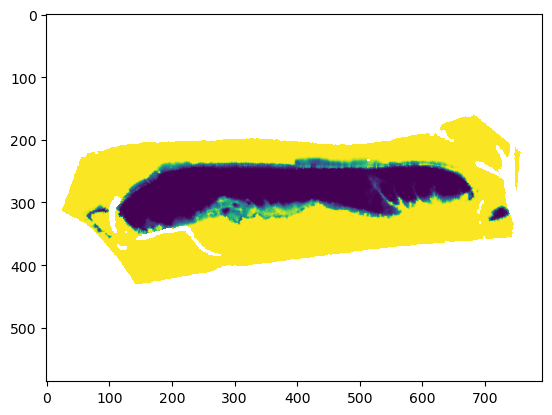

In [11]:
fig, ax = plt.subplots()
ax.imshow(rot_ds[-10, ...])

In [12]:
def get_rotated_vertex(center, point, angle):
    """
    Computes new coordinates of a rectangle vertex after rotation

    Input:
        - center, the center point of the rectangle
        - point, the original vertex point
        - angle, the rotation angle of the rectangle

    Output:
        - rotated_point, the new coordinates of point after rotation
    """
    # Translate point such that 'rectangle' has center at (0, 0)
    new_point = np.array(point) - np.array(center)
    # Create rotation matrix
    rot_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )
    # Compute rotated point
    rotated_point = np.matmul(rot_matrix, new_point)
    # translate point back
    rotated_point = rotated_point + np.array(center)
    return rotated_point

def fit_array_to_bounds(array, array_bounds, center, extent, angle):
    """
    Crops the array to the extent. This assumes that array is rotated by angle degrees
    and extent is the extent after rotation. array bounds are the original bounds before rotation

    Input:
        - array, a 'rotated' array which we want to crop
        - array_bounds, the bounds or extent of the original array before rotation
        - center, the center point of the extent to which we want to crop
        - extent, the extent to which we want to crop
        - angle, the rotation angle of the array

    Output:
        - array, the cropped array
        - dx, the distance one cell in x direction represents
        - dy, the distance one cell in y direction represents
    """
    left, bottom, right, top = array_bounds

    # Compute new vertex positions after rotation
    xmin1 = get_rotated_vertex(center, (left, bottom), np.deg2rad(angle))[0]
    ymin1 = get_rotated_vertex(center, (right, bottom), np.deg2rad(angle))[1]
    xmax1 = get_rotated_vertex(center, (right, top), np.deg2rad(angle))[0]
    ymax1 = get_rotated_vertex(center, (left, top), np.deg2rad(angle))[1]

    # Get extent of area of interest
    xmin2, ymin2, xmax2, ymax2 = extent

    # Assumes that array dimensions are (y, x) or (z, y, x)
    if len(array.shape) == 2:
        # Compute dx and dy
        dx = np.round((xmax1 - xmin1) / array.shape[1])
        dy = np.round((ymax1 - ymin1) / array.shape[0])

        # Compute bounds (in indices) corresponding to extent
        # Note that ymax1 and ymax2 are the actual coordinate values, therefore the ymin index is computed using ymax coordinates
        xmin = int((xmin2 - xmin1) / dx)
        xmax = int(array.shape[1] - (xmax1 - xmax2) / dx)
        ymin = int((ymax1 - ymax2) / dy)
        ymax = int(array.shape[0] - (ymin2 - ymin1) / dy)

        array = array[ymin:ymax, xmin:xmax]
    elif len(array.shape) == 3:
        # Compute dx and dy
        dx = np.round((xmax1 - xmin1) / array.shape[2])
        dy = np.round((ymax1 - ymin1) / array.shape[1])

        # Compute bounds (in indices) corresponding to extent
        # Note that ymax1 and ymax2 are the actual coordinate values, therefore the ymin index is computed using ymax coordinates
        xmin = int((xmin2 - xmin1) / dx)
        xmax = int(array.shape[2] - (xmax1 - xmax2) / dx)
        ymin = int((ymax1 - ymax2) / dy)
        ymax = int(array.shape[1] - (ymin2 - ymin1) / dy)

        array = array[:, ymin:ymax, xmin:xmax]
    return (array, dx, dy)

In [13]:
(
    conc,
    dx_conc,
    dy_conc,
) = fit_array_to_bounds(
    rot_ds,
    conc_bounds,
    mid_point,
    lims,
    -angle,
)

(592561.530811512, 607623.7318780796)

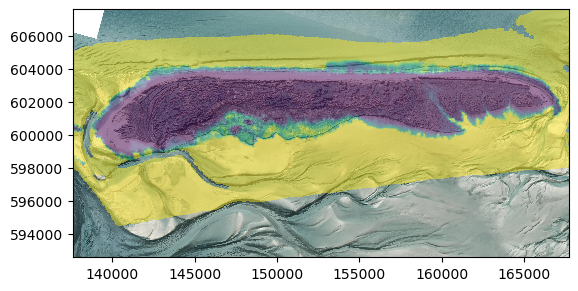

In [14]:
fig, ax = plt.subplots()

im = ax.imshow(img_shade, extent=plt_extent,
               clip_on=True, interpolation='none'
)
im_contour = ax.imshow(conc[-10, ...], extent=(lims[0], lims[2], lims[1], lims[3]), alpha=0.5)

transform = mtransforms.Affine2D().rotate_deg_around(
    mid_point[0], mid_point[1], -angle
)
trans_data = transform + ax.transData
im.set_transform(trans_data)

ax.set_xlim(lims[0], lims[2])
ax.set_ylim(lims[1], lims[3])